In [1]:
import os
import mne
import random
import numpy as np
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader
from src.train import train, plot_metrics

from src.models.attn_cond_eegnet_subjectFeatures import ConditionedEEGNet
from src.dataset.MI_dataset_single_subject import MI_Dataset
from config.over60 import cfg
from config.over60_withbaseline import cfg as cfg_baseline


from utils.eval import accuracy
from utils.model import print_parameters, print_weights_statistics

%load_ext autoreload
%autoreload 2


Calculate the average signal of each subect

Give this average to the model, to learn from it


In [2]:
def extract_features(epochs: mne.Epochs) -> np.ndarray:
    """
    Extracts various features from MNE epochs object across multiple frequency bands,
    and returns them as a numpy array.

    Parameters:
    epochs (mne.Epochs): The epochs object with EEG data.

    Returns:
    np.ndarray: An array containing 12 averaged features across epochs.
    """
    # Define frequency bands
    bands = [(8, 13), (13, 18), (18, 25)]

    # Initialize list to collect features
    feature_values = []

    # Extract data from epochs
    data = epochs.get_data()
    sfreq = epochs.info['sfreq']

    # Calculate features for each band
    for fmin, fmax in bands:
        psds, freqs = mne.time_frequency.psd_array_multitaper(data, sfreq=sfreq, fmin=fmin, fmax=fmax, verbose=False)

        average_power = np.mean(psds, axis=(1, 2))
        sum_power = np.sum(psds, axis=(1, 2))
        peak_frequency = freqs[np.argmax(psds, axis=2)].mean(axis=1)

        feature_values.append(np.mean(average_power))
        feature_values.append(np.mean(sum_power))
        feature_values.append(np.mean(peak_frequency))

    # Overall features across all bands
    psds, _ = mne.time_frequency.psd_array_multitaper(data, sfreq=sfreq, fmin=8, fmax=25, verbose=False)
    overall_average_power = np.mean(psds)
    overall_sum_power = np.sum(psds)
    overall_std_dev_power = np.std(np.mean(psds, axis=(1, 2)))

    feature_values.extend([overall_average_power, overall_sum_power, overall_std_dev_power])

    return np.array(feature_values)


In [3]:
###  Calculate USER AVERAGE FEATURE
### TODO HASH CACHE
subject_features = {}
for subject_id in cfg_baseline['data']['subjects']:
    print("Subject ID: ", subject_id)
    # TODO exclude test runs
    runs = cfg_baseline['data']['train_runs'][subject_id] + cfg_baseline['data']['test_runs'][subject_id]
    dataset = MI_Dataset(cfg_baseline, subject_id, runs=runs)

    epochs = dataset.epochs
    subject_features[subject_id] = extract_features(epochs)
  

Subject ID:  1
Subject ID:  2
Subject ID:  3
Subject ID:  7
Subject ID:  8


In [4]:
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [5]:
train_dataset = MI_Dataset.get_concat_dataset(cfg, split='train', return_subject_number = True, device=device, verbose=False)
train_dataloader = DataLoader(train_dataset, batch_size=cfg['train']['batch_size'], shuffle=True)
print(f"Train dataset: {len(train_dataset)} samples")

test_dataset = MI_Dataset.get_concat_dataset(cfg, split='test', return_subject_number = True, device=device, verbose=False)
test_dataloader = DataLoader(test_dataset, batch_size=cfg['train']['batch_size'], shuffle=False)
print(f"Test dataset: {len(test_dataset)} samples")

Loading dataset from cache\all_subjects_with_id_1-2-3-7-8\train_dataset.pkl...
Train dataset: 1200 samples
Loading dataset from cache\all_subjects_with_id_1-2-3-7-8\test_dataset.pkl...
Test dataset: 240 samples


In [6]:
model = ConditionedEEGNet.from_config(cfg['model'], subject_features, cfg["data"]["subjects"], device)
print_parameters(model)


eeg_encoder.conv1.weight.... --> 250
eeg_encoder.bn1.weight...... --> 25
eeg_encoder.bn1.bias........ --> 25
eeg_encoder.dw_conv1.weight. --> 550
eeg_encoder.bn2.weight...... --> 25
eeg_encoder.bn2.bias........ --> 25
eeg_encoder.sep_conv1.weight --> 400
eeg_encoder.conv2.weight.... --> 1600
eeg_encoder.bn3.weight...... --> 64
eeg_encoder.bn3.bias........ --> 64
eeg_bn.embed.weight......... --> 7680
eeg_norm.weight............. --> 768
eeg_norm.bias............... --> 768
eeg_dim_reduction.weight.... --> 4608
eeg_dim_reduction.bias...... --> 6
subject_encoder.weight...... --> 144
subject_encoder.bias........ --> 12
subject_bn.embed.weight..... --> 120
subject_norm.weight......... --> 12
subject_norm.bias........... --> 12
subject_dim_reduction.weight --> 72
subject_dim_reduction.bias.. --> 6
classifier.weight........... --> 24
classifier.bias............. --> 4

Total Parameter Count:...... --> 17264


In [ ]:
loss, val_loss, train_acc, val_acc = train(model, train_dataloader, test_dataloader, cfg['train'])

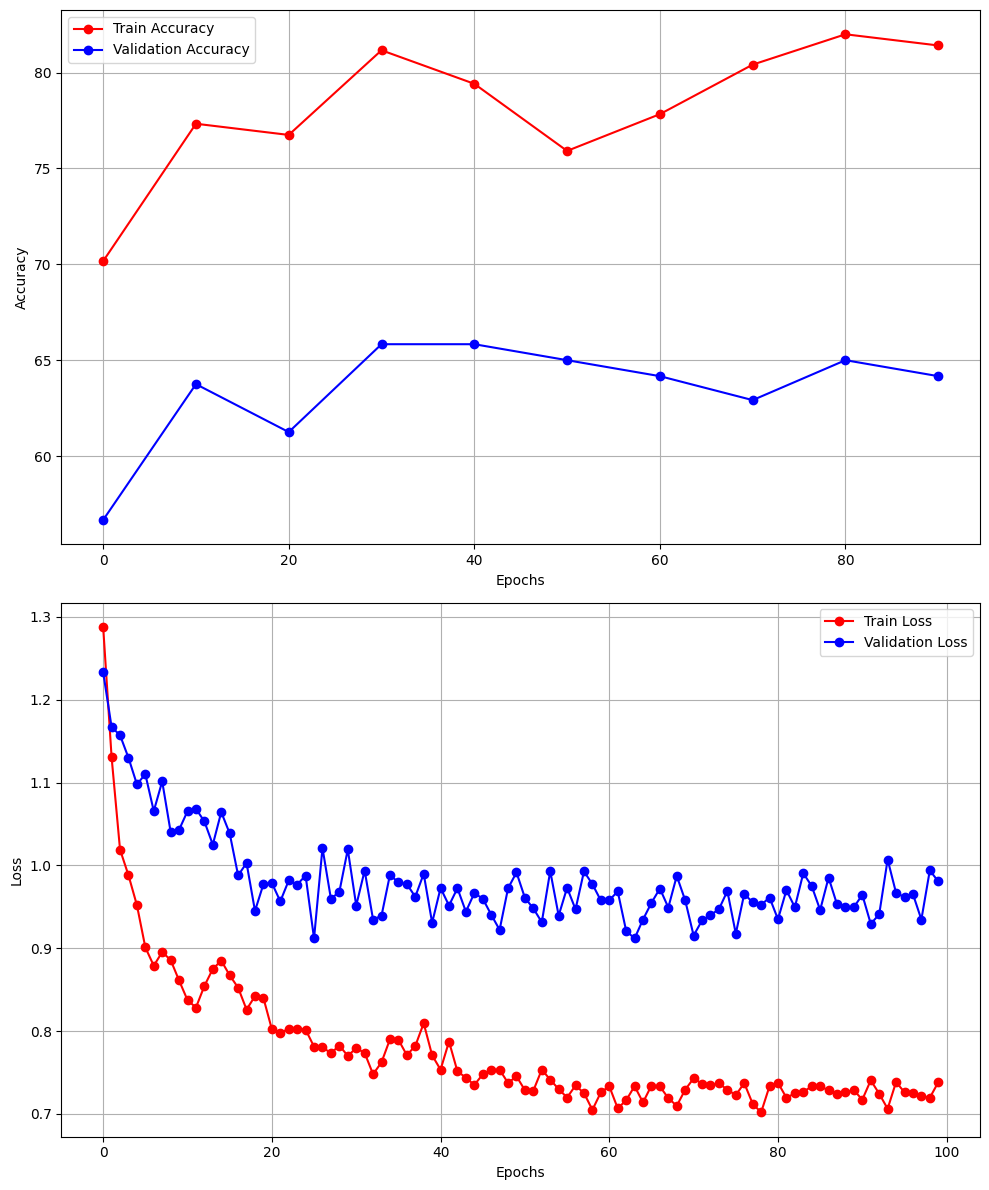

In [ ]:
plot_metrics(loss, val_loss, train_acc, val_acc)